In [264]:
import torch 
from torch import nn 
import pandas as pd 
from torch import optim 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
import timeit
from tqdm import tqdm 

In [265]:
RANDOM_SEED = 42
BATCH_SIZE =512
EPOCHS = 40 
LEARNING_RATE= 1e-44
NUM_CLASSES = 10 
PATCH_SIZE =4 
IMG_SIZE = 28 
INPUT_CHANNELS = 1 
NUM_HEADS = 8 # number of attention heads to use in transformer 
DROPOUT = 0.001
HIDDEN_DIM = 768 #Hidden dimension of MLP Head 
ADAM_WEIGHT_DECAY  = 0 #DEFAULT VALUES 
ADAM_BETAS = (0.9, 0.999)
ACTIVATION_FUNCTION= 'gelu'
NUM_ENCODERS = 4 
EMBED_DIM = (PATCH_SIZE**2)*INPUT_CHANNELS #4**2
NUM_PATCHES = (IMG_SIZE//PATCH_SIZE)**2 #(28/4)**2


np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic =True
torch.backends.cudnn.benchmark = False
                                                                                                       
device = "cuda" if torch.cuda.is_available() else "cpu" #only have cpu in this case


first part to implement is dividinf image into patches, creating cls tokens and then merging them with position embeddings 

In [267]:
class PatchEmbedding(nn.Module): 
    def __init__(self, embed_dim, patch_size,num_patches, dropout, in_channels):
        super().__init__() #invokdes the constructor of the base class(initializes the parent class-->nn.Module)
        self.patcher = nn.Sequential(
            nn.Conv2d(
            in_channels = in_channels, 
            out_channels = embed_dim, 
            kernel_size = patch_size,  
            stride = patch_size), 
            #It will take the image and divide it into image of patch size '
            nn.Flatten(2))
           
        #classification token 
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad = True) # learnable parameter 
        self.position_embeddings = nn.Parameter(torch.randn(size = (1, num_patches + 1, embed_dim)), requires_grad = True) # learnable parameter
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x): 
        #initializing the cls token, expand it with the shape of our imput (x) 
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) # -1 means we won't change the dimension)
        x = self.patcher(x).permute(0,2,1)
        x = torch.cat([cls_token, x], dim =1) # merges the cls token with the patches 
        x += self.position_embeddings 
        x= self.dropout(x)
        return x
        
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, INPUT_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28) 
print(model(x).shape) 

#torch.Size([512, 50, 16]) (size, number of tokens we will feed, size of the patches)                             

torch.Size([512, 50, 16])


In [268]:
class ViT(nn.Module):
    def __init__(self, num_patches, igm_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels): 
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        #transport transformer encoder from pytorch 
        encoder_layer = nn.TransformerEncoderLayer(d_model= embed_dim, nhead = num_heads, dropout=dropout, activation = activation, batch_first = True, norm_first =True) #when we define our images, the batch size comes first
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers = num_encoders)
        
        self.mlp_head =nn.Sequential(
            nn.LayerNorm(normalized_shape= embed_dim), 
            nn.Linear(in_features =embed_dim, out_features=num_classes))
        
    def forward(self, x): 
        x=self.embeddings_block(x)
        x= self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])   #only take cls token is fed to the MLP head as only that is used for further classfiication 
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION_FUNCTION, INPUT_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28)
print(model(x).shape)
        


c:\Users\arses\.ai-navigator\micromamba\envs\cpu\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 10])


In [269]:
train_df = pd.read_csv("Downloads/digit-recognizer-challenge/train.csv")
test_df = pd.read_csv("Downloads/digit-recognizer-challenge/test.csv")
submission_df= pd.read_csv("Downloads/digit-recognizer-challenge/sample_submission.csv")

In [270]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [271]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [272]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [273]:
train_df, val_df = train_test_split(train_df, test_size = 0.1, random_state = RANDOM_SEED, shuffle = True)

In [274]:
class MNISTTrainDataset(Dataset): 
    def __init__(self, images, labels, indices): 
        self.images= images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToPILImage(), 
            transforms.RandomRotation(15), #rotates images randomly by 15 degrees, only apply this on the training dataset
            transforms.ToTensor(), 
            transforms.Normalize([-.5], [0.5])
            
        ])
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx): 
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index= self.indices[idx]
        image= self.transform(image)
        return {"image":image, "label":label, "index":index}
        
    #since this is a pytorch dataset, we nieed init, length, and get items functions 
        

Validation dataset is super similar, however, does not contain data augmentation or rotation

In [276]:
class MNISTValDataset(Dataset): 
    def __init__(self, images, labels,  indices): 
        self.images= images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize([-.5], [0.5])
            
        ])
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx): 
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index= self.indices[idx]
        image= self.transform(image)
        
        return {"image":image, "label":label, "index":index}
        
    #since this is a pytorch dataset, we nieed init, length, and get items functions 
        

In [277]:
class MNISTSubmitDataset(Dataset): 
    def __init__(self, images,  indices): 
        self.images= images
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize([-.5], [0.5])
            
        ])
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx): 
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index= self.indices[idx]
        image= self.transform(image)
        
        return {"image":image, "index":index}
        
    #since this is a pytorch dataset, we nieed init, length, and get items functions 

37800
{'image': tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000,

<Figure size 640x480 with 0 Axes>

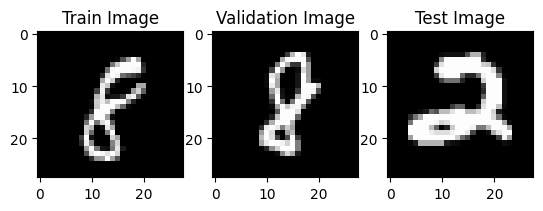

In [278]:
plt.figure()
f, axarr = plt.subplots(1,3)

train_dataset = MNISTTrainDataset(train_df.iloc[:,1:].values.astype(np.uint8), train_df.iloc[:,0].values, train_df.index.values) 
print(len(train_dataset)) 
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap = "gray") #squeeze to get rid of the input channel 
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:,1:].values.astype(np.uint8), val_df.iloc[:,0].values, val_df.index.values) 
print(len(val_dataset)) 
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap = "gray") #squeeze to get rid of the input channel 
axarr[1].set_title("Validation Image")
print("-"*30)

#for test, we will only feed images and indices. But we will remove iloc, because there is no label in the first place 
test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8),  test_df.index.values) 
print(len(test_dataset)) 
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap = "gray") #squeeze to get rid of the input channel 
axarr[2 ].set_title("Test Image")
print("-"*30)

plt.show()

In [293]:
#define dataloaders 
train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle= True)

val_dataloader = DataLoader(dataset = val_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle= True)

test_dataloader = DataLoader(dataset = test_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle= False)


Now, moving on to the training loop 